In [9]:
# test skills

# for each skill
    # for n tests
    #   reset env
    #   execute skill
    #   timeout or success
# success rate for each skill

import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
import gym
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset
import sys
from collect_skill_trajectories import get_all_goal_value, from_real_dict_to_vector, ZONE_OBS_DIM
from stable_baselines3 import PPO
from train_dynamics import VFDynamics, VFDynamicsMLP
import rtamt
import time
#from gym.wrappers import RecordVideo
from gym.wrappers.monitor import video_recorder as VR
import math
from tqdm import tqdm
sys.path.append("/app/vfstl/src/GCRL-LTL/zones")
from envs import ZoneRandomGoalEnv
from envs.utils import get_zone_vector
from rl.traj_buffer import TrajectoryBufferDataset

def main():
            # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("CUDA is available. Training on GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Training on CPU.")

    def cost_fn(state):
        return torch.randn(state.size()[0])
    
    model_path = '/app/vfstl/src/GCRL-LTL/zones/models/goal-conditioned/best_model_ppo_4'
    model_path = '/app/vfstl/src/GCRL-LTL/zones/logs/ppo/traj_exp/best_model'
    policy_model = PPO.load(model_path, device=device)
    timeout = 1000
    env = ZoneRandomGoalEnv(
        env=gym.make('Zones-8-v0', timeout=timeout), 
        primitives_path='/app/vfstl/src/GCRL-LTL/zones/models/primitives', 
        goals_representation=get_zone_vector(),
        use_primitves=True,
        rewards=[0, 1],
        device=device,
    )

    # [success_num, total_num, success_steps_num]
    run_stastics = {'J':[0, 0], "W": [0, 0], "R":[0, 0], "Y": [0, 0]}
    run_suc_steps = {'J':[], "W": [], "R":[], "Y": []}
    epochs = 1000
    for i in tqdm(range(epochs)):
        obs = env.reset()
        done = False
        success = False
        num_steps = 0
        while not (done or success):
            obs = {'obs':env.current_observation()}
            action, _ = policy_model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action) 
            success = (reward == 1)
            num_steps+=1
            if success:
                run_stastics[env.current_goal()][0]+=1
                run_suc_steps[env.current_goal()].append(num_steps)
        run_stastics[env.current_goal()][1]+=1
        if(i % 100 == 0): 
            print(run_stastics)
        
    print(run_stastics)
    return run_stastics, run_suc_steps

SyntaxError: invalid syntax (1688038976.py, line 68)

In [8]:
stas, suc_stas = main()

CUDA is available. Training on GPU.


  0%|          | 0/1000 [00:01<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
stas

{'J': [2, 2], 'W': [3, 3], 'R': [3, 3], 'Y': [2, 2]}

In [4]:
suc_stas

{'J': [156, 101], 'W': [155, 124, 141], 'R': [100, 113, 88], 'Y': [300, 109]}

In [10]:
J = np.array(suc_stas['J'])

In [42]:
for key in suc_stas:
    n = np.array(suc_stas[key])
    
    print("{} max:{}, min:{}, ave:{}".format(key, np.max(n), np.min(n), np.average(n)))
    print("number of all points: {}".format(n.size))
    print("number of bigger than 500: {}".format(n[n>1000].size))
    print("number of bigger than 200: {}".format(n[n>200].size))
    print("number of bigger than 100: {}".format(n[n>100].size))

J max:1262, min:45, ave:174.224
number of all points: 250
number of bigger than 500: 2
number of bigger than 200: 64
number of bigger than 100: 159
W max:4552, min:46, ave:201.416
number of all points: 250
number of bigger than 500: 3
number of bigger than 200: 63
number of bigger than 100: 160
R max:1250, min:46, ave:170.136
number of all points: 250
number of bigger than 500: 1
number of bigger than 200: 44
number of bigger than 100: 169
Y max:1990, min:47, ave:175.5506072874494
number of all points: 247
number of bigger than 500: 3
number of bigger than 200: 63
number of bigger than 100: 154


In [40]:
from matplotlib.pyplot import boxplot
from matplotlib.pyplot import subplot

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff33b4dc3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff33b4dcf10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff33b4dc110>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff33b4aa450>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff33b4aa950>],
 'means': []}

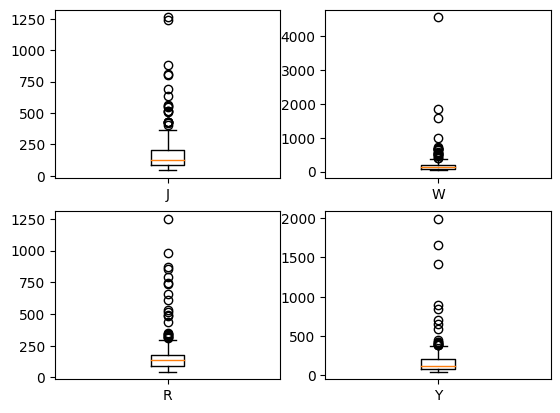

In [41]:
subplot(2,2,1)
boxplot(np.array(suc_stas['J']), labels='J')
subplot(2,2,2)
boxplot(np.array(suc_stas['W']), labels='W')
subplot(2,2,3)
boxplot(np.array(suc_stas['R']), labels='R')
subplot(2,2,4)
boxplot(np.array(suc_stas['Y']), labels='Y')